# Problem set 5: Clustering

## Description

**The goal of this problem set is to compute and explore three different clusterings of historical court records.**

## Imports and setup

In [126]:
%matplotlib inline
import numpy as np
import os
from   sklearn.cluster import KMeans, SpectralClustering, DBSCAN, OPTICS, AgglomerativeClustering
from   sklearn.datasets import make_blobs
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Our input text file
old_bailey_file = os.path.join('..', '..', 'data', 'old_bailey', 'old_bailey.txt')

## Convenience functions

Creating visualizations of your data and pulling sample texts for individual comparison are important parts of assessing the performance of your model. To make these two tasks easier, I've provided a function to do each one.

Note that the visualization function performs dimension reduction, so that we can plot high-dimensional text data in 2-D space. The clustering operations are performed on the original, high-dimensional data.

In [127]:
# Plotting function
def plot_compare(X, labels, title, reduce=True, alpha=0.2):
    '''
    Takes an array of object data, a set of cluster labels, and a title string
    Reduces dimensions to 2 and plots the clustering.
    Returns nothing.
    '''
    import matplotlib.pyplot as plt
    import seaborn as sns
    from   sklearn.decomposition import TruncatedSVD

    if reduce:
        # TruncatedSVD is fast and can handle sparse inputs
        # PCA requires dense inputs; MDS is slow
        coordinates = TruncatedSVD(n_components=2).fit_transform(X)
    else:
        # Optionally handle 2-D inputs
        coordinates = X
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(12,6))

    # Unlabeled data
    plt.subplot(121) # 1x2 plot, position 1
    plt.scatter(
        coordinates[:, 0], 
        coordinates[:, 1], 
        alpha=alpha, # Set transparency so that we can see overlapping points
        linewidths=0 # Get rid of marker outlines
    )
    plt.title("Unclustered data")

    # Labeled data
    plt.subplot(122)
    sns.scatterplot(
        x=coordinates[:, 0], 
        y=coordinates[:, 1],
        hue=labels,
        alpha=alpha,
        palette='viridis',
        linewidth=0
    )
    plt.title(title)
    plt.show()
    
# Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    '''
    Takes lists of texts and an array of labels, as well as number of samples to return per label.
    Prints sample texts belonging to each label.
    '''
    texts_array = np.array(texts) # Make the input text list easily addressable by NumPy
    for label in np.unique(labels): # Iterate over labels
        print("Label:", label)
        sample_index = np.where(labels == label)[0] # Limit selection to current label
        print("Number of texts in this cluster:", len(sample_index), '\n')
        chosen = np.random.choice(sample_index, size=n) # Sample n texts with this label
        for choice in chosen:
            print("Sample text:", choice)
            print(texts_array[choice], '\n') # Print each sampled text
        print("###################################")

## Synthetic example

To see how clustering works in `scikit-learn` (it's really easy!), here's a synthetic example.

Note that `X` and `y` are the conventional labels for an input data array and a vector of labels, respectively. You don't have to use these (and may well want to at least give your variables informative suffixes), but you'll see this notation a lot.

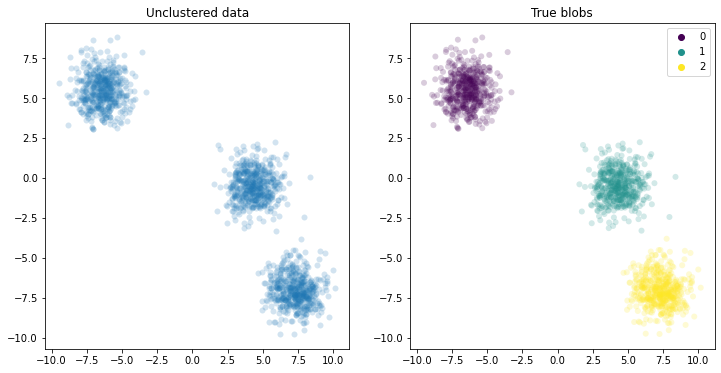

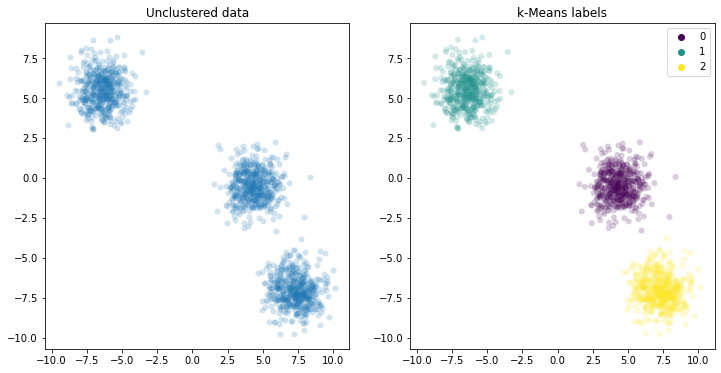

In [128]:
n_samples = 1500 # this many points per blob
X, y = make_blobs(n_samples=n_samples) # Make data and true labels
y_pred = KMeans(n_clusters=3).fit_predict(X) # Perform clustering

plot_compare(X, y, 'True blobs', reduce=False)
plot_compare(X, y_pred, 'k-Means labels', reduce=False)
# print(type(X))

That's it! Notice that all we needed was to construct input data, set up a clustering object, and call the `fit_predict` method on the input data.

This is what you'll do for the graded portions to follow.

## Old Bailey records

We'll work with a set of 3,090 short text documents from the Old Bailey, the main criminal court of the city of London. These records are a small subset of the almost 200,000 total digitized records collected by [The Old Bailey Proceedings Online](https://www.oldbaileyonline.org/static/Project.jsp).

Our versions of the records have had most names removed. We need to perform some preprocessing, then vectorize the documents.

Note that the file with which we're working collects all the records into a single document. Individual cases are delimited with two newlines, hence we split on `'\n\n'`.

In [129]:
# Read cases in as a list of strings
with open(old_bailey_file, 'r') as f:
    bailey = [doc for doc in f.read().split('\n\n')] # split on consecutive newlines
print("Total documents:", len(bailey))

Total documents: 3090


## 0. Pre-reflection (10 points)

Reflect briefly on what you expect to find in the data. What types of cases to you expect the court to have adjudicated? How many of each type might you expect? What might be the important differences between case types? How cleanly do you expect the different cases to be separated?

To be honest, I am not too sure what to expect from the court proceedings from the Old Bailey. However, I think there will be 3 types of adjudications. One being innocence, another being guilty (with prison), and another being guilty (death penalty). I could be wrong in assuming this since I am not very well-versed in court proceedings. But I think it would be safe to assume these would be the distinctions made for differentiating cases- the outcome. Also, when thinking about how 'cleanly' these cases will be seperated, I feel the innocent verdicts will be seperated much more cleanly than the two types that are marked guilty.

## 1. Vectorize (5 points)

Using the vectorizer defined below, transform the input documents into a TFIDF-weighted document-term matrix. Store your vectorized output in a varaible named `X_bailey`.

Note: This should take one line of your own code!

In [130]:
# Custome preprocessing to remove escaped characters in input
def pre_proc(x):
    '''
    Takes a unicode string.
    Lowercases, strips accents, and removes some escapes.
    Returns a standardized version of the string.
    '''
    import unicodedata
    return unicodedata.normalize('NFKD', x.replace("\'", "'").replace("\ in\ form", " inform").lower().strip())

# Set up vectorizer
vectorizer = TfidfVectorizer(
    encoding='utf-8',
    preprocessor=pre_proc,
    min_df=2, # Note this
    max_df=0.8, # This, too
    binary=False,
    norm='l2',
    use_idf=True # And this
)

# Your code here
X_bailey = vectorizer.fit_transform(bailey)

# Get the dimensions of the doc-term matrix
print("Matrix shape:", X_bailey.shape)

Matrix shape: (3090, 8638)


In [131]:
# Freebie: Display a document and its vectorized features
doc = 1000 # Which document to use?
print("A sample document:\n", bailey[doc], '\n')
print("The document's features:\n", sorted(vectorizer.inverse_transform(X_bailey[doc])[0]))

A sample document:
 was indicted for stealing, on the 30th of July , two table cloths, value 40 s.; one coat, value 10 s.; one waistcoat, value 5 s.; and one hat, value 5 s., the goods of Sir , Bart. , in his dwelling-house . . I am servant to Sir H. Lushington. On Monday the 30th of July, between two and three o'clock in the afternoon, the door, which leads to the passage from the area, was opened by some person, I had latched it ten minutes before, and went to sit in a room with my fellow servants and heard it open. I immediately ran into the area - a person said a man had just ran up the steps with some things under his arm - we ran after him, I caught sight of him twice with the things - I will not swear to the prisoner. I still followed and got to Berkley-mews; he dropped the things - I picked them up, and still followed - the prisoner was taken in Adam-street, West, he had the same kind of coat on, and appeared the same man. The things were Sir H. Lushington's property. . I heard

In [132]:
# Freebie: Check that we've retained gendered pronouns in our vectorization
for pronoun in ['she', 'her', 'hers', 'he', 'him', 'his']:
    print(pronoun, '\t', pronoun in vectorizer.get_feature_names())

she 	 True
her 	 True
hers 	 True
he 	 True
him 	 True
his 	 True


## 2. Perform *k*-Means clustering (15 points)

Perform *k*-Means clustering with `n_clusters=3` on your vectorized data. See the synthetic example above for guidance and/or consult the scikit-learn [kMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) documentation.

Specifically, you must:

1. Perform the clustering and store your output labels in variable named `y_kmeans`
1. Print the shape of your label vector (it should match the number of documents in the input data set)
1. Plot the resulting clustering using the supplied `plot_compare` function

You should be able to accomplish these tasks in a few lines of code.

In [142]:
# Perform k-Means clustering with n_clusters = 3
y_kmeans = KMeans(n_clusters=3).fit(X_bailey)
print(y_kmeans.labels_.shape)

(3090,)


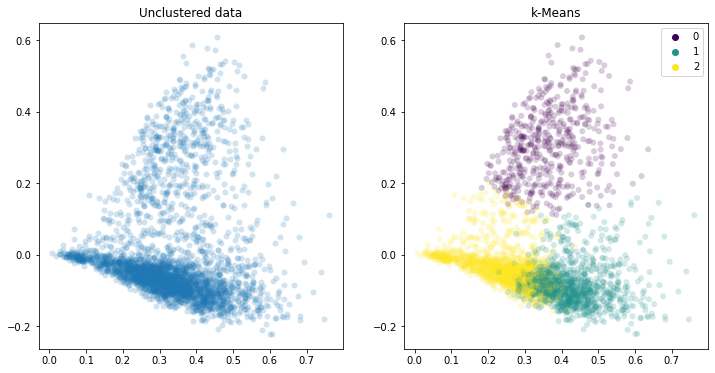

In [143]:
# Plot k-Means results
plot_compare(X_bailey, y_kmeans.labels_, 'k-Means', reduce=True)

## 3. Analyze *k*-Means clustering results (15 points)

Use the supplied `pull_samples` function to examine 5 documents from each cluster (5 points). Then, write a paragraph analyzing your results (10 points). 

Can you make sense of the clusters? Do the cases look like what you expected? Do the calculated clusters strike you as meaningfully distinct? Do you think justice was done in the cases you examined? Anything else that stands out?

In [125]:
# Pull k-Means samples
pull_samples(bailey, y_kmeans.labels_, n=5)

Label: 0
Number of texts in this cluster: 1465 

Sample text: 75
was indicted for stealing, on the 16th of December , one shirt, value 2 s. , the goods of . . I am the wife of James Carter , who is butcher , and lives in Brick-lane . I lost this shirt from Abbott's-place, Brick-lane; it hung out to dry. . About twelve o'clock, on the 16th of December, I saw the prisoner and another young man, going down Abbot's-court, I suspected them, and secured the prisoner as he was getting over Carter's palings with the shirt. (Property produced and sworn to.) Prisoner's Defence. I went down the court, and found it was no thoroughfare. I was picking something up, and Clitherow said I stole it. GUILTY . Aged 28. Confined Six Months . First Middlesex Jury, before Mr. Recorder. 

Sample text: 1674
was indicted for stealing, on the 1st of June , one cotton shawl, value 6 s. , the goods of . . On the 1st of June, I saw the prisoner take a shawl from Mr. Davis's door, and go away with it under his arm. 

These clusters do not really make too much sense to me. I initially thought they were seperated by either severity of the punishment or prehaps the verdict, but it does not really seem to be the case. It does, however, seem the first 2 labels definitely include more NOT GUILTY verdicts- especially the first label (Label 0). I can not really find a trend or pattern for distinguishing other than that. It was quite hard for me to read these cases, there was a lot of language I was confused about, but I think in some cases was not done. Also, it is very hard to decide that since some of these cases provide very little context. There was one thing that stood out to me, which was that most of these crimes were on the basis of theft. I do not think that necessarily affects the clusters, but that is the biggest thing that stood out to me. 

## 4. Spectral clustering (30 points)

*k*-Means is just one approach to clustering. Here, you'll produce produce a **Spectral clustering**, with cosine similarity, as a point of comparison. You may want to consult the scikit-learn [SpectralClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html) documentation.

You must:

1. Set up a `SpectralClustering` object with `n_clusters=3` and `affinity='precomputed'`
1. Calculate the pairwise `cosine_similarity` matrix on your vectorized input data
1. Compute a spectral clustering on the cosine similarity matrix, storing the output labels in a variable named `y_spectral`
1. Print the shape of your output label vector
1. Plot your results using the `plot_compare` function
1. Pull and print 5 sample cases belonging to each cluster using the `pull_samples` function
1. Discuss the results of your spectral clustering, both on their own and in comparison to the *k*-Means results. About an honest aragraph should be sufficient.

In [106]:
# Your spectral clustering code
# cos_s = cosine_similarity(X_bailey)
y_spectral = SpectralClustering(n_clusters = 3, affinity = 'precomputed').fit(cosine_similarity(X_bailey))
print(y_spectral.labels_.shape)

(3090,)


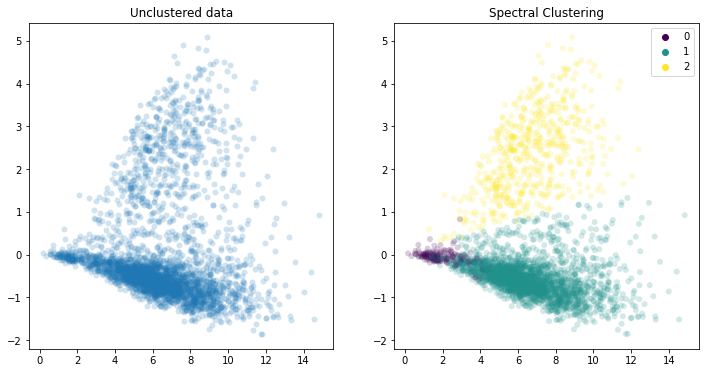

In [141]:
# Plot spectral results
plot_compare(cosine_similarity(X_bailey), y_spectral.labels_, 'Spectral Clustering', reduce=True)

In [108]:
# Pull spectral samples
pull_spec = pull_samples(bailey, y_spectral.labels_, n=5)

Label: 0
Number of texts in this cluster: 177 

Sample text: 578
was indicted for a misdemeanor . NOT GUILTY . London Jury, before Mr. Common Sergeant. 

Sample text: 419
and were indicted for stealing, on the 1st of December , two snuff-boxes, value 5 l.; one gold brooch, value 10 s., and 16 s., in monies numbered, the goods of , from his person . The prosecutor did not appear. NOT GUILTY . First Middlesex Jury, before Mr. . 

Sample text: 2882
was indicted for stealing, on the 30th of October , 1 watch, value 3l. 10s. , the goods of . The prisoner pleaded GUILTY . Aged 45. Transported for Seven Years . 

Sample text: 1600
was indicted for stealing five views of different places , the goods of Our Lord . The prisoner pleaded GUILTY . Confined One Month . Before Mr. Recorder. 

Sample text: 2944
was indicted for stealing, on the 15th of April , 9 yards of woollen cloth, value 3l.; 1 waistcoat, value 3s.; 1 pair of gaiters, value 2s.; 1 razor, value 2s., and 1 razor-case, value 3d., the

The first thing that I noticed was the lack of description for the first label (Label 0). I could not really identify who was being held under trial. Then, as I was reading through the trials from Label 1 and Label 2, these clusters were seperated by gender of the "criminal." Label 2 refers to those involved as "she/her" and Label 1 refers to those involved as "he/him." This has led me to believe that the Label has seperated each group depending on gender. I find it interesting that it seems, on average, that those who were not identified by a pronoun (Label 0) to have less harsh verdicts. When viewing Label 0 through the clustering visualization, it made sense that label 0 is so small- can't imagine a lot of these trials being so sort/not having specific gender identifers. 

## 5. Any other clustering method (25 points)

Perform the same steps as in the *k*-Means and Spectral clustering cases (set up with appropriate options, compute labels, print label vector dimensions, plot, pull samples, and discuss results), but using a different clustering method from among [those offered by scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering). Say something brief about why you chose the method you did as part of your discussion.

Note: You'll want to pay particular attention to data input formats and to any key parameters of your chosen clustering method. Just as Spectral clustering required an affinity (similarity) matrix as input, some methods want a precomputed distance or similarity matrix as input. Others are very sensitive to options (like epsilon in DBSCAN). Work with care and note in your discussion any choices that you feel were important.

In [158]:
from sklearn.metrics.pairwise import euclidean_distances
y_aggl = AgglomerativeClustering(n_clusters = 3).fit(euclidean_distances(X_bailey))
print(y_aggl.labels_.shape)

/Users/joshuahong/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


(3090,)


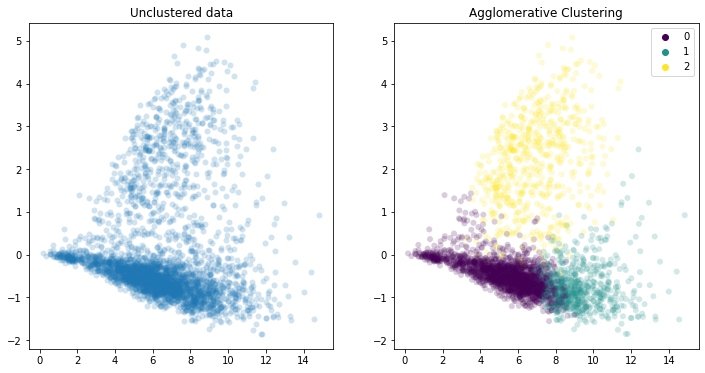

In [159]:
plot_compare(cosine_similarity(X_bailey), y_aggl.labels_, 'Agglomerative Clustering', reduce=True)

In [161]:
pull_aggl = pull_samples(bailey, y_aggl.labels_, n=5)

Label: 0
Number of texts in this cluster: 1818 

Sample text: 2553
was indicted for stealing, on the 30th of June , 1 sack of peas, value 9s. 6d. , the goods of . WILLIAM BISHOP. I am a salesman . On Saturday morning, the 30th of June, I was in the open part of Covent Garden-market , and had some peas for sale; and about half-past nine o'clock the prisoner was walking round my stand, with another man, who was bargaining for some peas - the prisoner walked to and fro with him, as I supposed to listen to the price; I agreed with the other man to take 9s. 6d. a sack; he put the money into my hand - I said I could not let him have the sack; he said he would return it- I then said, "Take your money back," which he did; after that I saw Green with a sack of peas; the prisoner was by his side - I sent Coles to tell him to come back - he was about thirty yards from my stand, and presently they sent me the sack back, but not the peas; no money had been offered for the peas. I took the prisoner 

What I used was agglomerative clustering which is apparently quite similar to k-means (especially since I used the 'ward' linkage). The clustering above uses the concept of hierarchical clustering, where clusters are merged successively, until the 3 shown above. I am not sure what the trends or decision for splitting is. I think the labels were most distinct when doing the spectral clustering, in addition I think using the cosine similarity did a lot for the spectral clustering. I think looking at euclidean distances- using agglomerative clustering- did not do a very good job in distinguishing the clusters. 